# **Introduction**

- This workbook attempts to construct a Convlutional Neural Network to classify COVID-19 and Pneumonia using chest x-ray images.

# **Setup**

- Import required packages

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Generate a `Dataset`**

In [11]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/chest-xray-covid19-pneumonia/Data/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/chest-xray-covid19-pneumonia/Data/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5144 files belonging to 3 classes.
Using 4116 files for training.
Found 5144 files belonging to 3 classes.
Using 1028 files for validation.


In [12]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [13]:
class_names = train_ds.class_names
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA']


# **Visualize the Data**
- First 9 Images from the dataset

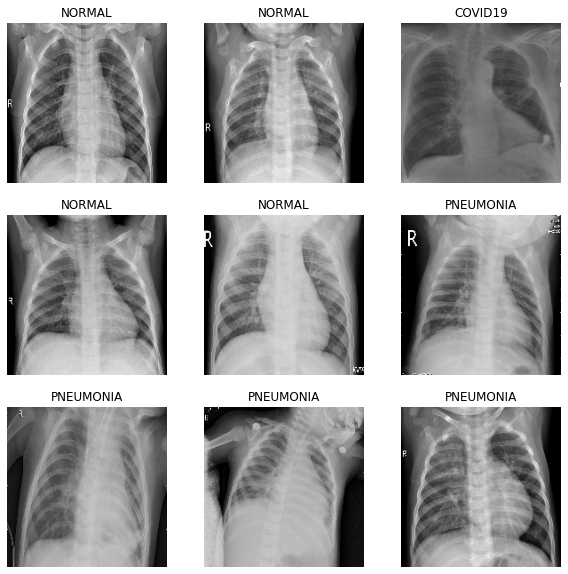

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Image Data Augmentation**

In [15]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

- The images after random augmentation

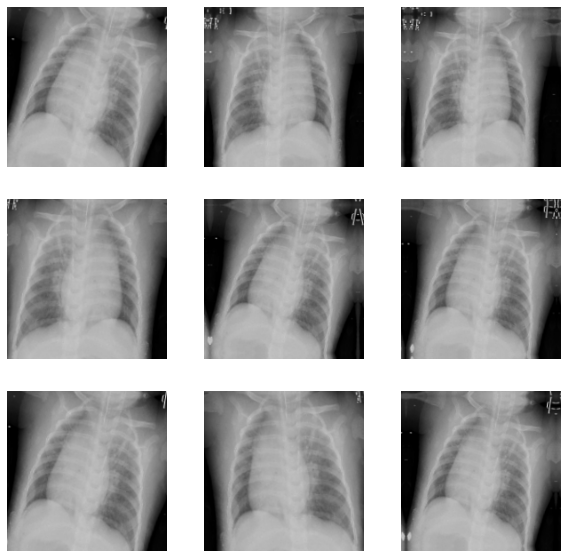

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## **Configure the dataset for performance**

In [17]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# **Build Model**

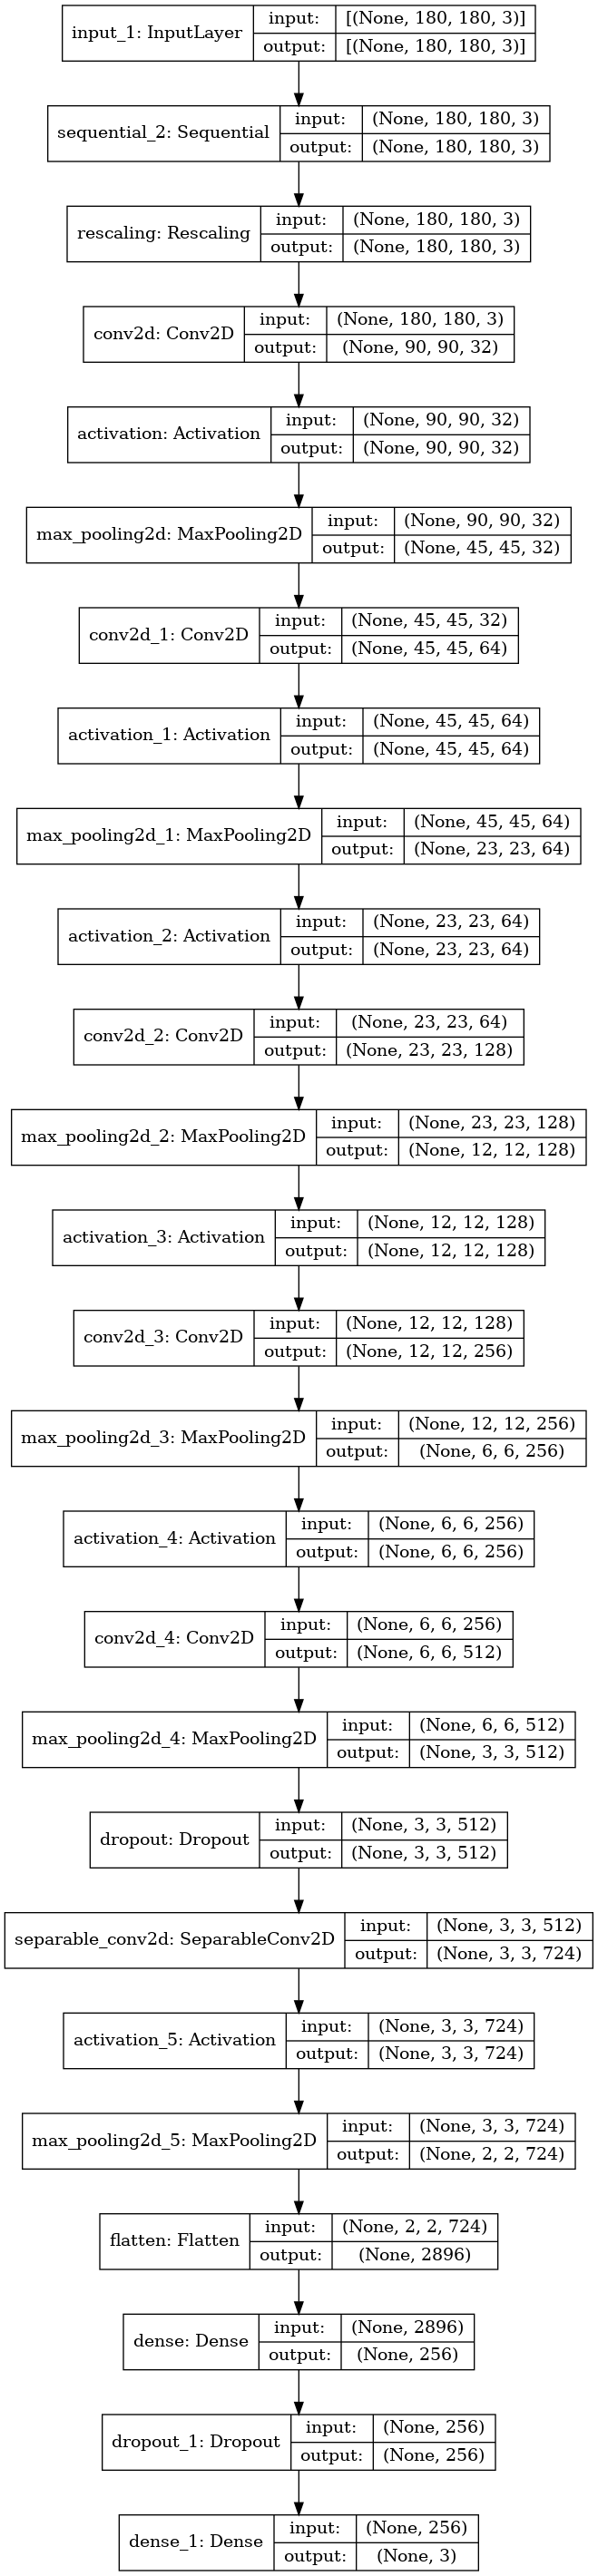

In [18]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

# **Define Callbacks**

In [19]:
# checkpoint_filepath = '/content/content'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=6,
#     verbose=0,
#     restore_best_weights = True)

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# **Train the Model**

In [20]:
epochs = 50

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [lr_callback],
    validation_data = val_ds)

Epoch 1/50
129/129 [==============================] - 205s 2s/step - loss: 0.9777 - accuracy: 0.6286 - val_loss: 0.8396 - val_accuracy: 0.6634
Epoch 2/50
129/129 [==============================] - 201s 2s/step - loss: 0.7918 - accuracy: 0.6826 - val_loss: 0.5967 - val_accuracy: 0.6732
Epoch 3/50
129/129 [==============================] - 201s 2s/step - loss: 0.5122 - accuracy: 0.7860 - val_loss: 0.3381 - val_accuracy: 0.8833
Epoch 4/50
129/129 [==============================] - 200s 2s/step - loss: 0.3746 - accuracy: 0.8634 - val_loss: 0.2451 - val_accuracy: 0.9037
Epoch 5/50
129/129 [==============================] - 201s 2s/step - loss: 0.3078 - accuracy: 0.9014 - val_loss: 0.3070 - val_accuracy: 0.8998
Epoch 6/50
129/129 [==============================] - 198s 2s/step - loss: 0.2705 - accuracy: 0.9095 - val_loss: 0.2210 - val_accuracy: 0.9193
Epoch 7/50
129/129 [==============================] - 199s 2s/step - loss: 0.2516 - accuracy: 0.9198 - val_loss: 0.2131 - val_accuracy: 0.9241

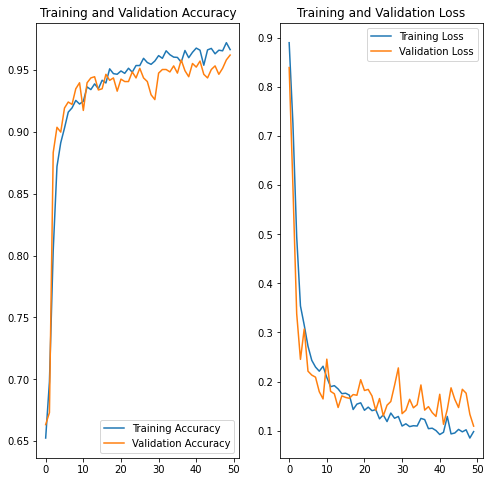

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
image_path = "../input/chest-xray-covid19-pneumonia/Data/test/COVID19/COVID19(471).jpg"
image_path2 = "../input/chest-xray-covid19-pneumonia/Data/test/NORMAL/NORMAL(1281).jpg"
image_path3 = "../input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3433).jpg"
merged_path = [image_path,image_path2,image_path3]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to COVID19 with a 57.59 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 48.81 percent confidence.
